_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [97]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

## Data Exploration

In [36]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [37]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,10,5,2015-07-31,7185,681,1,1
1,15,5,2015-07-31,9191,766,1,1
2,31,5,2015-07-31,7248,645,1,1
3,47,5,2015-07-31,9379,1021,1,1
4,53,5,2015-07-31,7540,690,1,1


In [38]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78400 entries, 0 to 78399
Data columns (total 7 columns):
Store            78400 non-null int64
DayOfWeek        78400 non-null int64
Date             78400 non-null object
Sales            78400 non-null int64
Customers        78400 non-null int64
Promo            78400 non-null int64
SchoolHoliday    78400 non-null int64
dtypes: int64(6), object(1)
memory usage: 4.2+ MB


In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78400 entries, 0 to 78399
Data columns (total 7 columns):
Store            78400 non-null int64
DayOfWeek        78400 non-null int64
Date             78400 non-null object
Sales            78400 non-null int64
Customers        78400 non-null int64
Promo            78400 non-null int64
SchoolHoliday    78400 non-null int64
dtypes: int64(6), object(1)
memory usage: 4.2+ MB


In [42]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
Store                        200 non-null int64
StoreType                    200 non-null object
Assortment                   200 non-null object
CompetitionDistance          199 non-null float64
CompetitionOpenSinceMonth    163 non-null float64
CompetitionOpenSinceYear     163 non-null float64
Promo2                       200 non-null int64
Promo2SinceWeek              36 non-null float64
Promo2SinceYear              36 non-null float64
PromoInterval                36 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 15.7+ KB


In [43]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            1
CompetitionOpenSinceMonth     37
CompetitionOpenSinceYear      37
Promo2                         0
Promo2SinceWeek              164
Promo2SinceYear              164
PromoInterval                164
dtype: int64

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [98]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Engineering

In [99]:
train = train.merge(store, on='Store')
test = test.merge(store, on='Store')

train.shape, test.shape

((78400, 16), (78400, 16))

In [100]:
train['Date'] = pd.to_datetime(train['Date'],  infer_datetime_format=True)
test['Date'] = pd.to_datetime(test['Date'],  infer_datetime_format=True)

train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
train['day'] = train['Date'].dt.day
test['day']  = test['Date'].dt.day

train = train.drop(columns='Date')
test = test.drop(columns='Date')

train = train.fillna(0)
test = test.fillna(0)

## Arranging X and Y Matrix

In [128]:
target = 'Sales'
features = train.columns.drop(target)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## Plot Before/After log 

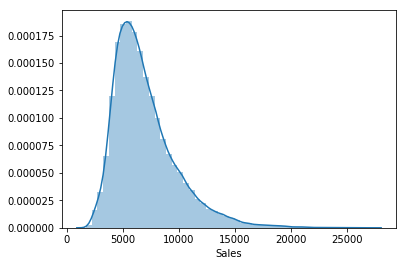

In [102]:
# Before Log Transformation
sns.distplot(y_train);

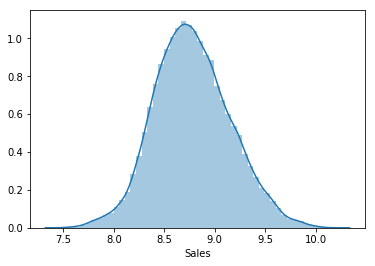

In [103]:
# After Log Transformation
sns.distplot(y_train_log);

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all rows for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all rows for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all rows for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [104]:
import category_encoders as ce
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [105]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=40)
)

groups = train['Store']
               
param_distributions = {
    'xgbregressor__n_estimators': randint(50,500),
    'xgbregressor__eta': uniform(0,1),
    'xgbregressor__max_depth': randint(3,12),
    'xgbregressor__gamma': randint(0,3),
    'xgbregressor__subsample': uniform(0,1)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=11, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=4
)

search.fit(X_train, y_train_log, groups=groups);

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done  18 out of  22 | elapsed:  1.6min remaining:   20.7s
[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:  1.7min finished


[13:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [106]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__eta': 0.9668708416780647, 'xgbregressor__gamma': 1, 'xgbregressor__max_depth': 11, 'xgbregressor__n_estimators': 292, 'xgbregressor__subsample': 0.8795424646711384}
Cross-validation RMSLE 0.17357168038108445


In [107]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__eta,param_xgbregressor__gamma,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,param_xgbregressor__subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
8,29.650194,0.283015,0.184161,0.000479,0.966871,1,11,292,0.879542,"{'xgbregressor__eta': 0.9668708416780647, 'xgb...",-0.026298,-0.033956,-0.030127,0.003829,1,-0.004047,-0.004074,-0.004061,0.000014
2,11.941903,0.015767,0.117242,0.000591,0.957305,2,5,265,0.849934,"{'xgbregressor__eta': 0.9573054291040197, 'xgb...",-0.025039,-0.035761,-0.030400,0.005361,2,-0.005416,-0.005189,-0.005302,0.000114
5,33.577365,0.015476,0.136707,0.002592,0.878102,2,10,348,0.497853,"{'xgbregressor__eta': 0.878102185789884, 'xgbr...",-0.024286,-0.037507,-0.030896,0.006611,3,-0.005694,-0.005780,-0.005737,0.000043
4,43.803760,0.515506,0.196305,0.001605,0.610153,1,10,476,0.782456,"{'xgbregressor__eta': 0.6101528374852048, 'xgb...",-0.026761,-0.035732,-0.031247,0.004486,4,-0.004105,-0.004097,-0.004101,0.000004
1,15.613696,0.130138,0.167475,0.008129,0.156199,1,5,376,0.913704,"{'xgbregressor__eta': 0.15619890109315815, 'xg...",-0.027067,-0.035481,-0.031274,0.004207,5,-0.004183,-0.004245,-0.004214,0.000031
7,6.535862,0.006887,0.133331,0.008993,0.240948,1,4,160,0.965263,"{'xgbregressor__eta': 0.24094758091740898, 'xg...",-0.027107,-0.036689,-0.031898,0.004791,6,-0.004542,-0.004386,-0.004464,0.000078
3,4.261632,0.049334,0.105382,0.003549,0.538079,1,8,67,0.967937,"{'xgbregressor__eta': 0.53807882601782, 'xgbre...",-0.028313,-0.037746,-0.033030,0.004717,7,-0.004140,-0.004105,-0.004122,0.000017
10,2.186875,0.028594,0.070703,0.005020,0.609468,0,3,59,0.349085,"{'xgbregressor__eta': 0.6094682042275313, 'xgb...",-0.025960,-0.041190,-0.033575,0.007615,8,-0.010698,-0.006822,-0.008760,0.001938
6,12.088703,0.041819,0.807805,0.012297,0.022389,0,9,162,0.292058,"{'xgbregressor__eta': 0.02238899759483748, 'xg...",-0.030793,-0.036547,-0.033670,0.002877,9,-0.001397,-0.001472,-0.001434,0.000038
0,5.765562,0.007881,0.202816,0.012863,0.59107,0,5,132,0.587526,"{'xgbregressor__eta': 0.5910698229023827, 'xgb...",-0.030874,-0.036612,-0.033743,0.002869,10,-0.002636,-0.002573,-0.002604,0.000031


In [108]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=40, eta=0.9668708416780647, 
                 max_depth=11, n_estimators=292, gamma=1,
                 subsample=0.8795424646711384)
)

pipeline.fit(X_train, y_train_log)

[13:34:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['StoreType', 'Assortment', 'PromoInterval'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'StoreType', 'mapping': c      1
a      2
d      3
NaN   -2
dtype: int64, 'data_type': dtype('O')...a=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8795424646711384, verbosity=1))])

In [109]:
y_test_pred = pipeline.predict(X_test)

rmse(y_test_log, y_test_pred)

0.14169723334928394

## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [110]:
import eli5
from eli5.sklearn import PermutationImportance

In [111]:
encoder = ce.OrdinalEncoder()
X_test_encoded = encoder.fit_transform(X_test)
X_train_encoded = encoder.fit_transform(X_train)

In [112]:
permuter = PermutationImportance(pipeline, scoring='neg_mean_squared_error',
                                cv='prefit', n_iter=2, random_state=40)

permuter.fit(X_test_encoded, y_test_log)
feature_names = X_test_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2668 ± 0.0004,Customers
0.0092 ± 0.0000,Promo
0.0036 ± 0.0000,CompetitionDistance
0.0013 ± 0.0000,DayOfWeek
0.0012 ± 0.0000,month
0.0008 ± 0.0000,Promo2
0.0007 ± 0.0000,day
0.0007 ± 0.0000,year
0.0003 ± 0.0000,CompetitionOpenSinceMonth
0.0001 ± 0.0000,SchoolHoliday


## Model After Feature Selection

In [113]:
print('Shape before romiving features:', X_train.shape)

Shape before romiving features: (78400, 17)


In [137]:
X_train.head()

,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,year,month,day
0,5,1498,1,1,620.0,9.0,2009.0,0,2015,7,31
1,4,1276,1,1,620.0,9.0,2009.0,0,2015,7,30
2,3,1258,1,1,620.0,9.0,2009.0,0,2015,7,29
3,2,1191,1,1,620.0,9.0,2009.0,0,2015,7,28
4,1,1379,1,1,620.0,9.0,2009.0,0,2015,7,27


In [138]:
X_test.head()

,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,year,month,day
0,5,681,1,1,3160.0,9.0,2009.0,0,2015,7,31
1,4,556,1,1,3160.0,9.0,2009.0,0,2015,7,30
2,3,518,1,1,3160.0,9.0,2009.0,0,2015,7,29
3,2,593,1,1,3160.0,9.0,2009.0,0,2015,7,28
4,1,662,1,1,3160.0,9.0,2009.0,0,2015,7,27


In [129]:
mask = permuter.feature_importances_> 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_test = X_test[features]

Shape after removing features: (78400, 11)


In [139]:
# Already encoded
X_train_encoded = X_train
X_test_encoded = X_test
model = XGBRegressor(random_state=40, eta=0.9668708416780647, 
                 max_depth=11, n_estimators=292, gamma=1,
                 subsample=0.8795424646711384)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_test_encoded)
print(f'Validation RMSLE', rmse(y_test_log, y_pred_log))

[13:51:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE 0.14323732196617237


## Partial Dependence Plots

In [124]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

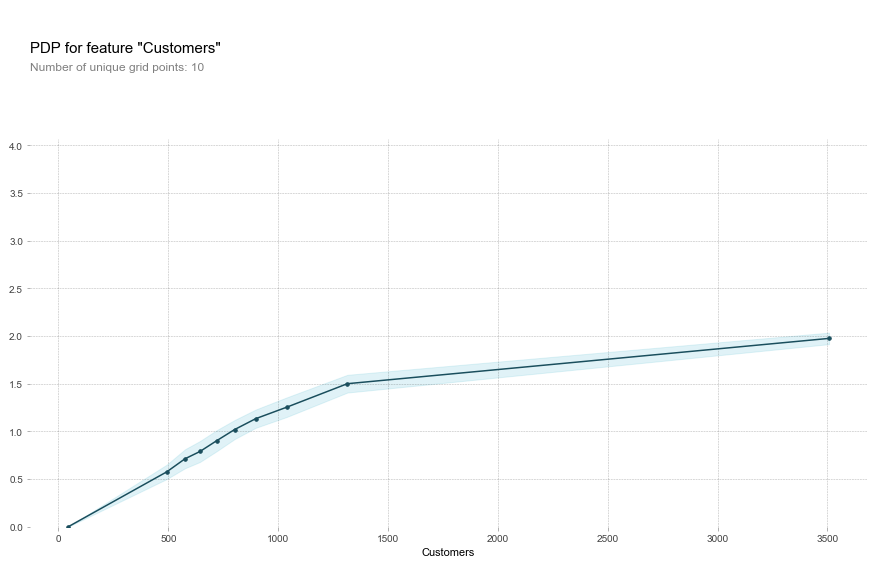

In [140]:
feature = 'Customers'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

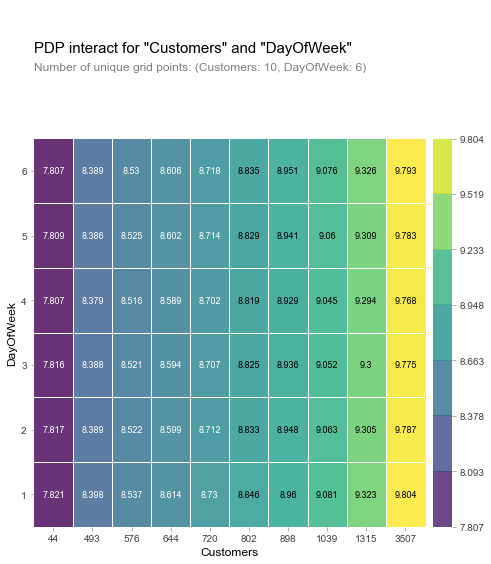

In [141]:
features = ['Customers', 'DayOfWeek']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);